PRODUCES: joint probes (Upsgm, Upsgg, beta) covariances, from simulations and with added shape noise, for use in the analysis.


This is a notebook to implement getting the covariance via a combination of simulations and adding shape noise via sampling from an independent covariance matrix.

This is used to generate the joint Upsilon_{gm}, Upsilon_{gg}, beta covariance matrices in the paper. The EG covariance matrices in the paper should be drawn from this.

In [1]:
import numpy as np
import cov_script as cs
import matplotlib
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=240)
import pyccl as ccl
import add_shape_noise as sn
import specs as sp
import utils as u 

Get the correlation matrix of Ups_gm, Ups_gg and beta, using simulations and additional shape-noise modelling

In [2]:
sims_Lbox = 1380 # Mpc/h
sims_vol = sims_Lbox**3 # (Mpc/h)^3
rp0 = 1.5

lens = 'DESI'
src = 'LSST'

# Let's use the same cosmological parameters as Shadab's simulations:
h=0.69
OmB = 0.022/h**2

#As is selected to match the sigma8 value we are using alongside other parameters. 

params = {'mu_0': 0., 'sigma_0':0., 'OmB':OmB, 'h':h, 'n_s':0.965, 'A_s':2.115 * 10**(-9), 'b':2.33, 'OmM': 0.292} 

In [3]:
# Load the rp bin info and make required cuts

up_gm_noSN_file = 'test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-gxm-sel-crossparticles-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon'
ups_jk_noSN = np.loadtxt('../data_for_Danielle/'+up_gm_noSN_file)
ups_jk_noSN_only = ups_jk_noSN[:,4:]

rp = ups_jk_noSN[:,0]
rp_edg = u.rp_bin_edges_log(rp)

ind = next(j[0] for j in enumerate(rp_edg) if j[1]>rp0)
rp_cut = rp[ind:]
rp_edg_cut = rp_edg[ind:]

# process the upg_gm and ups_gg data but just to plot the samples and see what they look like
ups_gm_samps = ups_jk_noSN_only[ind:,:]

#Load upsgg
up_gg_noSN_file = 'test-HOD-PB00-z0.75-w1pz_cat-zRSD-model-5-sel-All-wtag-w1-rfact10-bin1-wp-logrp-pi-NJN-100.txt.upsilon'
upsgg_jk_noSN = np.loadtxt('../data_for_Danielle/'+up_gg_noSN_file)
upsgg_jk_noSN_only = upsgg_jk_noSN[:,4:]

ups_gg_samps = upsgg_jk_noSN_only[ind:, :]


In [4]:
# Plot the jackknife samples, just to see what they look like:

plt.figure()
for i in range(0,len(ups_gm_samps[0,:])):
    plt.loglog(rp_cut, ups_gm_samps[:,i])
plt.savefig('../plots/upsgm_jksamps.pdf')
plt.close()


plt.figure()
for i in range(0,len(ups_gg_samps[0,:])):
    plt.loglog(rp_cut, ups_gg_samps[:,i])
plt.savefig('../plots/upsgg_jksamps.pdf')
plt.close()

In [5]:
# Get the shape-noise only covariance for Upgm
Cov_SN_Ups = sn.cov_SN_only(rp_edg_cut,lens,src, params, rp0)

Now compute and load the covariance matrix *without* shape noise.

In [6]:
cov_corr_dict = cs.evaluate_correlation_matrix(stat_list=['gm','gg', 'beta'],rmin=rp0,plots=0,data_dir='../data_for_Danielle/',  add_shape_noise=False, lens=lens, src=src)

par= gm
par= gg


In [7]:
# Extend the shape-noise matrix and add them together:
Cov_SN_full = np.zeros((31,31))
for i in range(0,15):
    for j in range(0,15):
        Cov_SN_full[i,j] = Cov_SN_Ups[i,j]

cov_with_SN = cov_corr_dict['cov'] + Cov_SN_full

In [8]:
print(cov_with_SN.shape)
# Okay, so we know there are 15 rp bins for Upgg and Upgm, and one value of beta. Beta is at the end (checked)

(31, 31)


We want to put things in units of Msol * h / pc^2 to match the rest of the code. The factor to get them in the same units is rho_crit (in particular units).

In [9]:
mperMpc = 3.0856776*10**22
Msun = 1.989*10**30 # in kg
Gnewt = 6.67408*10**(-11) # kg^{-1}m^3 s^{-2}
c=2.99792458*10**(8) # m / s
rho_crit = 3. * 10**10 * mperMpc / (8. * np.pi * Gnewt * Msun) / 10**12  
# rho crit in Msol h^2 / Mpc / pc^2, to yield Upsilon_gg in Msol h / pc^2

OmegaM = 0.292

For Upsilon x beta, we should multiply by a single factor of rho_crit. For Upsilon x Upsilon, two factors.
In the case of Upsilon_gm, the sims stuff also has a missing factor of Omega_M whic we need to add.

We also rescale to account for the difference between the volume of our survey set up and the volume of the sim.

In [10]:
# Covariance goes like 1/volume, so multiply sims terms by sims_vol / us_vol to go to us_vol

vol_LSST_DESI = sp.volume(params, src, lens)
volume_factor = sims_vol / vol_LSST_DESI
print(volume_factor)

0.43070682763608437


In [11]:
# Do the rescaling to my units and LSST+DESI volume
rpbins=15

cov_sims_myunits = np.zeros_like(cov_with_SN)

# Ups_gm x Ups_gg
# Rescale by: volume factor, Omega_M*rho_crit**2 (= rho_M**2)
cov_sims_myunits[0:rpbins,0:rpbins] = rho_crit**2*volume_factor*OmegaM**2*cov_with_SN[0:rpbins, 0:rpbins] # gm x gm

# Ups_gm x Ups_gg
# Rescale by: volume_factor, Omega_M*rho_crit (= rho_m), rho_crit
cov_sims_myunits[0:rpbins,rpbins:2*rpbins] = rho_crit**2*volume_factor*OmegaM*cov_with_SN[0:rpbins, rpbins:2*rpbins] #gm x gg
cov_sims_myunits[rpbins:2*rpbins,0:rpbins] = rho_crit**2*volume_factor*OmegaM*cov_with_SN[rpbins:2*rpbins, 0:rpbins] #gm x gg

# Ups_gg x Ups_gg
# Rescale by: volume_factor, rho_crit^2
cov_sims_myunits[rpbins:2*rpbins, rpbins:2*rpbins] = rho_crit**2*volume_factor*cov_with_SN[rpbins:2*rpbins, rpbins:2*rpbins] #gg x gg

# Ups_gm x beta
# Recale by: volume factor, rho_crit*OmegaM
cov_sims_myunits[2*rpbins,0:rpbins] = rho_crit*OmegaM*volume_factor*cov_with_SN[2*rpbins, 0:rpbins] # gm x beta
cov_sims_myunits[0:rpbins,2*rpbins] = rho_crit*OmegaM*volume_factor*cov_with_SN[0:rpbins,2*rpbins] # gm x beta

# Ups_gg x beta from sims
# Rescale by: volume factor, rho_crit
cov_sims_myunits[2*rpbins,rpbins:2*rpbins] = rho_crit*volume_factor*cov_with_SN[2*rpbins, rpbins:2*rpbins] # gg * beta
cov_sims_myunits[rpbins:2*rpbins,2*rpbins] = rho_crit*volume_factor*cov_with_SN[rpbins:2*rpbins, 2*rpbins] # gg x beta

# beta x beta
# Rescale by volume factor
cov_sims_myunits[2*rpbins,2*rpbins] = volume_factor*cov_with_SN[2*rpbins, 2*rpbins] # beta x beta

In [12]:
# Get the corresponding correlation matrix too:
corr_sims_myunits = np.zeros_like(cov_sims_myunits)
for i in range(0,len(cov_sims_myunits[0,:])):
    for j in range(0,len(cov_sims_myunits[:,0])):
        corr_sims_myunits[i,j] = cov_sims_myunits[i,j] / np.sqrt(cov_sims_myunits[i,i] * cov_sims_myunits[j,j])  

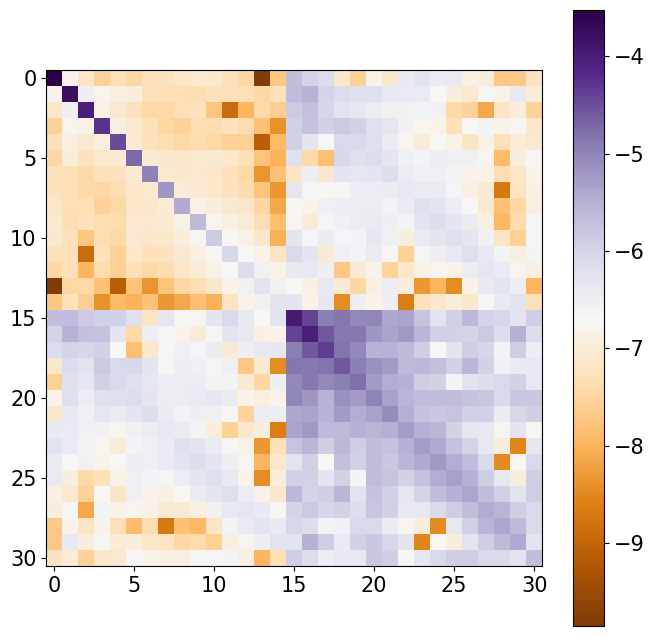

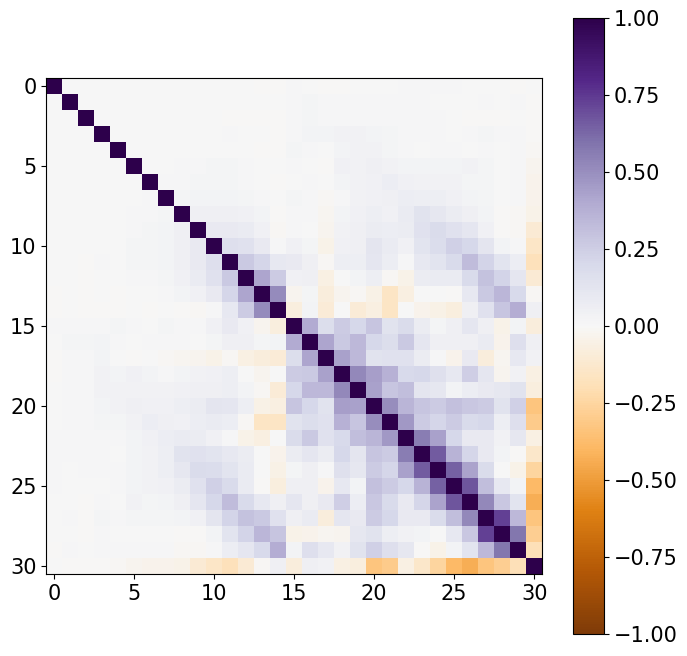

In [13]:
cmap=plt.get_cmap('PuOr')

# Visualize the full covariance and correlation matrix - sims
plt.figure(figsize=[8,8])
plt.imshow(np.log10(np.abs(cov_sims_myunits)), cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
#plt.savefig('../plots/sims_cov_myunits_log10_FIXSN_rp0=1.5_Y10.pdf')
plt.show()



plt.figure(figsize=[8,8])
plt.imshow(corr_sims_myunits,cmap=cmap, vmin=-1, vmax=1)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
cbar2 = plt.colorbar()
cbar2.ax.tick_params(labelsize=15)
#plt.savefig('../plots/sims_corr_myunits_FIXSN_rp0=1.5_Y10.pdf')
plt.show()

In [ ]:
# Output the simulations correlation and covariance in my units in case we need this:

np.savetxt('../txtfiles/sims_cov_Msolunits_LSSTY1_addSNmat.dat', cov_sims_myunits)
np.savetxt('../txtfiles/sims_corr_Msolunits_LSSTY1_addSNmat.dat', corr_sims_myunits)
np.savetxt('../txtfiles/rp_bins_mid_plot_addSNmat.txt', rp_cut)

Load the analytic covariance matrix for visual comparison

In [14]:
cov_analytic= np.loadtxt('../txtfiles/joint_covariance_rp0=1.5_Oct2024.dat')

In [15]:
# Get the correlation matrix for the analytic covariance too:

# Get the corresponding correlation matrix too:
corr_analytic = np.zeros_like(cov_analytic)
for i in range(0,len(cov_analytic[0,:])):
    for j in range(0,len(cov_analytic[:,0])):
        corr_analytic[i,j] = cov_analytic[i,j] / np.sqrt(cov_analytic[i,i] * cov_analytic[j,j]) 

/tmp/ipykernel_1497295/8554482.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cov_analytic)),cmap=cmap)


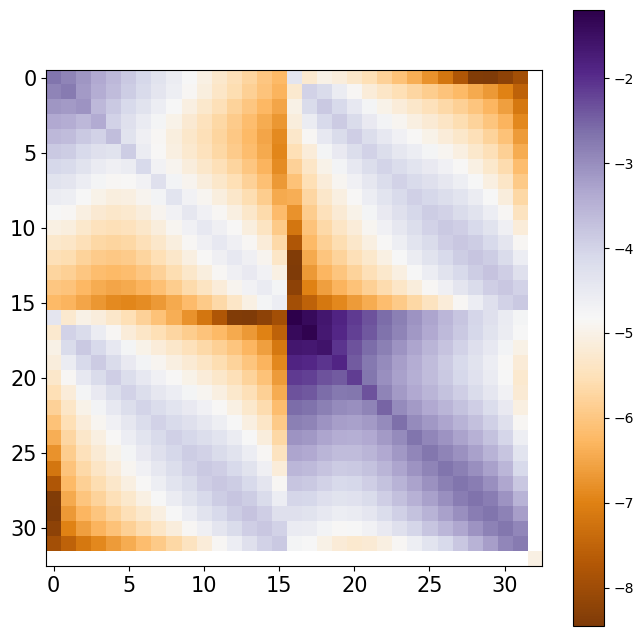

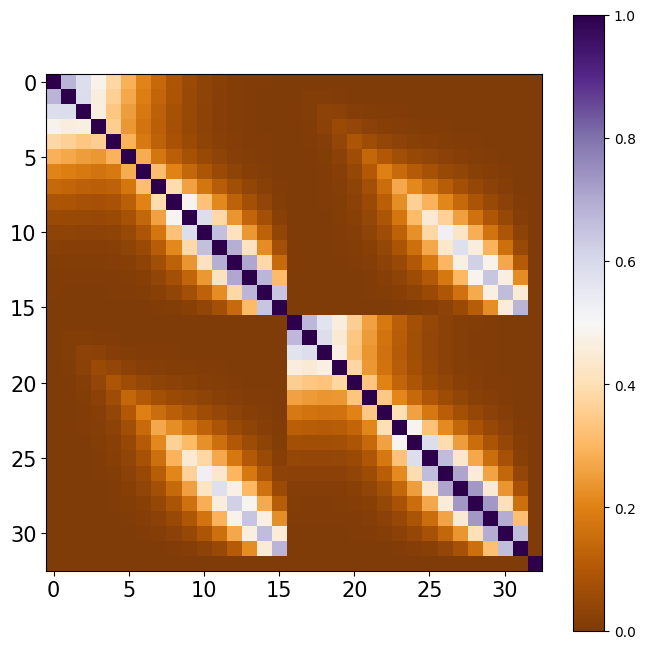

In [17]:
# Visualise the covariance and correlation matrix from my analytic code:

cmap=plt.get_cmap('PuOr')

plt.figure(figsize=[8,8])
plt.imshow(np.log10(np.abs(cov_analytic)),cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
#plt.savefig('../plots/analytic_cov_log10_rp=1.5.pdf')
plt.show()

plt.figure(figsize=[8,8])
plt.imshow(corr_analytic, cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.colorbar()
#plt.savefig('../plots/analytic_corr_rp=1.5.pdf')
plt.show()